# Exploracion de Datos

## Descripcion del Dataset

El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.



In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random
import json
import ast
import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

random.seed(0)

DATASET = 'dataset/meli_dataset_20190426.csv'

In [3]:
df_raw = pd.read_csv(DATASET, low_memory=False)

df = df_raw.copy()

In [4]:
df.shape

(499948, 13)

In [5]:
df.dropna().shape

(261273, 13)

El dataset cuenta con 499948 entradas compuestas por 13 variables de las cuales 5 son numericas, 6 son categoricas y 2 son tipo documento, de estas ultima una es una lista de atributos en formato JSON lines y la otra es texto libre correspondiente al titulo de la publicacion.

Tambien comprobamos que de el total de entradas 261273, el 52.2%, poseen algun valor nulo.



In [6]:
var_cont = ['SHP_WEIGHT','SHP_LENGTH','SHP_WIDTH','SHP_HEIGHT','PRICE']
var_cat = ['ITEM_ID', 'CATALOG_PRODUCT_ID', 'CONDITION', 'DOMAIN_ID', 'SELLER_ID', 'STATUS']
var_condensed = ['ATTRIBUTES','TITLE']

### Variables Numericas

In [7]:
df.describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE
count,347751.000000,347751.000000,347751.000000,347751.000000,3.685440e+05
mean,1854.789579,31.451148,21.290276,11.578580,1.206323e+03
std,3257.884009,18.339895,11.217308,8.310821,5.018810e+05
min,1.000000,0.000000,0.000000,0.000000,1.000000e-01
25%,260.000000,20.000000,13.000000,5.000000,4.490000e+01
50%,675.000000,25.000000,20.000000,10.000000,9.500000e+01
75%,1900.000000,36.000000,25.000000,16.000000,1.720000e+02
max,50000.000000,288.200000,165.000000,105.000000,3.032487e+08


### Variables Categoricas 

In [8]:
df.describe(include = ['O'])

,ITEM_ID,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,SELLER_ID,STATUS,TITLE
count,499948,368544,499948,368544,367555,421587,499948,421587
unique,384501,245622,15553,3,2853,61781,6,306233
top,EZ118KZWRZ,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-VEHICLE_ACCESSORIES,XYDSNCU3UV,active,Maquininha Point Mini - A Máquina De Cartão Do...
freq,275,16435,450354,365978,9100,842,226459,297


### Variables Auxiliares de Procesamiento
Agregaremos algunas variables que nos serviran para el analisis posteriormente

In [9]:
# Tiene dimension valida, mayor que cero y no nulo
df['HAS_DIM'] = (~df.SHP_LENGTH.isna()) & (df.SHP_LENGTH > 0)

In [10]:
# Pertenece a una categoria con una poblacion significativa de mas de 30
sig_items = df.ITEM_ID.value_counts() > 30
sig_items_id = sig_items[sig_items].index
df['IS_SIG_ITEM'] = df.ITEM_ID.isin(sig_items_id)

In [11]:
# Pertenece a un dominio con una poblacion significativa de mas de 30
sig_domain = df.DOMAIN_ID.value_counts() > 30
sig_domain_id = sig_domain[sig_domain].index
df['IS_SIG_DOM'] = df.DOMAIN_ID.isin(sig_domain_id)

## Analisis de valores no existentes

Como pudimos ver en el punto anterior podemos ver que contamos con gran cantidad de valores no existentes. Veamos un resumen de los valor faltantes por variable y por entrada.

In [12]:
# NAs por columna
df.isna().sum()

ITEM_ID                    0
SHP_WEIGHT            152197
SHP_LENGTH            152197
SHP_WIDTH             152197
SHP_HEIGHT            152197
ATTRIBUTES            131404
CATALOG_PRODUCT_ID         0
CONDITION             131404
DOMAIN_ID             132393
PRICE                 131404
SELLER_ID              78361
STATUS                     0
TITLE                  78361
HAS_DIM                    0
IS_SIG_ITEM                0
IS_SIG_DOM                 0
dtype: int64

Notamos la coincidencia en el numero de valores faltantes entre SHP_WEIGHT, SHP_LENGTH, SHP_WIDTH y SHP_HEIGHT; ATTRIBUTES, CONDITION y PRICE; al igual que SELLER_ID y TITLE. Analicemos ahora si los faltantes son los mismos o se trata de valores diferentes que solon coinciden en la cantidad.

In [13]:
[(df.SHP_WEIGHT.isna() != df.SHP_LENGTH.isna()).sum(),
(df.SHP_WEIGHT.isna() != df.SHP_WIDTH.isna()).sum(),
(df.SHP_WEIGHT.isna() != df.SHP_HEIGHT.isna()).sum()]
# tenemos 347751 entras que poseen todas las dimensiones, las demas no tienen ninguna

[0, 0, 0]

In [14]:
[(df.ATTRIBUTES.isna() != df.CONDITION.isna()).sum(),
(df.ATTRIBUTES.isna() != df.PRICE.isna()).sum()]

[0, 0]

In [15]:
(df.SELLER_ID.isna() != df.TITLE.isna()).sum()

0

Comprobamos que los datos faltantes coinciden entre los grupos. Entonce si a una entrada le falta una dimension, le faltaran todas; si no tiene atributos tampoco tendra precio o condicion. Y si no tiene vendedor tampoco tendra descripcion.

### Imputacion de dimensiones ###

Dada la naturaleza del problema nos concentraremos en los faltantes dentro de las dimensiones. Trataremos de buscar la manera de recuperar parte de los datos. Existen varias maneras de lidear con los faltantes, la mas simple es eliminar la entrada aunque en esa caso perderiamos la informacion de todos los campos. Por otro lado podriamos reemplazarlo por la mediana de la variable aunque este dato no seria necesariamente cierto. 

Para minimizar este error, para cada entrada con dimensiones no existentes, buscaremos todas las publicaciones similiras y trataremos de obtener las dimensiones a partir de ellas. Por ejemplo:

La publicacion con mas envios realizados es ITEM_ID = EZ118KZWRZ , correspondiente al Mini-Point de cobro de Mercado Pago

In [16]:
df_point = df[df.ITEM_ID == 'EZ118KZWRZ']
df_point.SHP_HEIGHT.value_counts(dropna=False)

NaN     114
4.0     104
10.0     55
6.0       1
20.0      1
Name: SHP_HEIGHT, dtype: int64

Vemos que dentro de una misma publicacion existen envios que no tienen valores de dimensiones, e inclusive entre los valores que poseen dimensiones las mismas no son homogeneas ya que hay diferentes valores en diferentes envios.

A continuacion vemos un histograma con los diferentes valores que adquieren las dimensiones

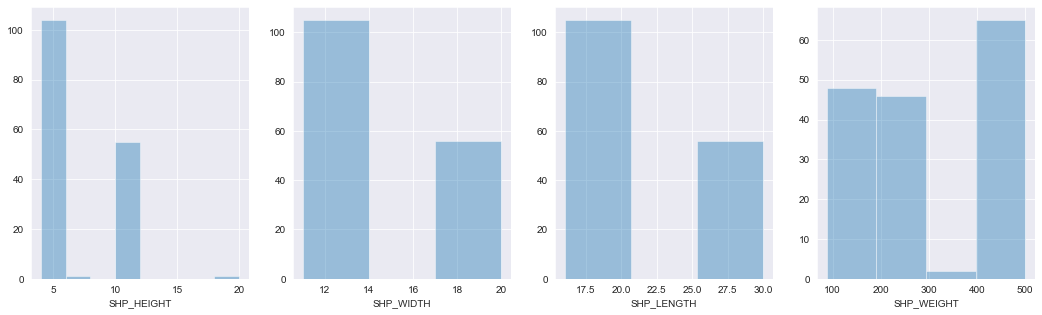

In [17]:
f, axes = plt.subplots(1, 4, figsize=(18, 5))

g = sns.distplot(df_point.SHP_HEIGHT.dropna(), kde = False,  label= 'Altura de Envíos', ax=axes[0])
g = sns.distplot(df_point.SHP_WIDTH.dropna(), kde = False, label= 'Ancho de Envíos', ax=axes[1])
g = sns.distplot(df_point.SHP_LENGTH.dropna(), kde = False, label= 'Largo de Envíos', ax=axes[2])
g = sns.distplot(df_point.SHP_WEIGHT.dropna(), kde = False, label= 'Peso de Envíos', ax=axes[3])

Lo que haremos a continuacion es reemplazar los NAs con la mediana en el caso de las variables numericas y con la moda para el caso de las variables categoricas. Sin embargo, dado que existen publicaciones con muy pocos envios aplicaremos este metodo solo para aquellas que posean mas de 30 muestras que es el limite que tomamos para considerar a la muestra como significativa.

In [18]:
ITEM_median = df[df.IS_SIG_ITEM & df.HAS_DIM].groupby('ITEM_ID').median()

Existen ITEM_ID que no poseen dimensiones en ninguna entrada por lo cual no pueden ser recuperados. Los identificamos para que no generen errores.

In [19]:
not_reco = (df[df.IS_SIG_ITEM].groupby('ITEM_ID').sum().HAS_DIM == 0)
not_reco_id = not_reco[not_reco].index

df['IS_RECO'] = ~df.ITEM_ID.isin(not_reco_id)

In [20]:
# Hacemos una lista de las entradas a las cuales recuperaremos sus dimensiones
to_add_dim = df[df.IS_SIG_ITEM & ~df.HAS_DIM & df.IS_RECO]
to_add_dim_id = to_add_dim.ITEM_ID.value_counts().index

In [21]:
# Cantidad de dimensiones recuperables
to_add_dim.shape

(1480, 17)

In [22]:
for id in to_add_dim_id:
    to_fill = to_add_dim[to_add_dim.ITEM_ID == id].fillna( value = ITEM_median.loc[id])
    df.loc[to_fill.index] = to_fill

In [23]:
df[var_cont].isna().sum()

SHP_WEIGHT    150772
SHP_LENGTH    150772
SHP_WIDTH     150772
SHP_HEIGHT    150772
PRICE         131404
dtype: int64

In [24]:
to_add_dim.head()

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO
12117,G9Y6QYEGTA,NaN,NaN,NaN,NaN,"[{'id': 'AUDIO_LANGUAGES', 'name': 'Idiomas de...",Y9AEZLRM1I,new,MLB-VIDEO_GAMES,199.0,N4DMSOED58,paused,Jogo God Of War Ps4,False,True,True,True
12118,G9Y6QYEGTA,NaN,NaN,NaN,NaN,"[{'id': 'AUDIO_LANGUAGES', 'name': 'Idiomas de...",Y9AEZLRM1I,new,MLB-VIDEO_GAMES,199.0,N4DMSOED58,paused,Jogo God Of War Ps4,False,True,True,True
12120,G9Y6QYEGTA,NaN,NaN,NaN,NaN,"[{'id': 'AUDIO_LANGUAGES', 'name': 'Idiomas de...",Y9AEZLRM1I,new,MLB-VIDEO_GAMES,199.0,N4DMSOED58,paused,Jogo God Of War Ps4,False,True,True,True
12121,G9Y6QYEGTA,NaN,NaN,NaN,NaN,"[{'id': 'AUDIO_LANGUAGES', 'name': 'Idiomas de...",Y9AEZLRM1I,new,MLB-VIDEO_GAMES,199.0,N4DMSOED58,paused,Jogo God Of War Ps4,False,True,True,True
12123,G9Y6QYEGTA,NaN,NaN,NaN,NaN,"[{'id': 'AUDIO_LANGUAGES', 'name': 'Idiomas de...",Y9AEZLRM1I,new,MLB-VIDEO_GAMES,199.0,N4DMSOED58,paused,Jogo God Of War Ps4,False,True,True,True


Pasamos de 152197 a 150772 valores sin dimensiones. La misma metodologia podria ser implementada nuevamente utilizando las categorias, sin embargo dado que solo queremos hacer visualizacion de los datos lo dejaremos de esta manera.

### Valores faltantes por entrada

In [25]:
# Cantidad de files por numero de NAs
df['n_nas_row'] =  df.isna().sum(axis=1)
df.n_nas_row.value_counts().sort_index()

0     262483
1        685
4     139561
5        304
6      51519
8      18554
10     26842
Name: n_nas_row, dtype: int64

Podemos ver que existe un gran numero de entradas que poseen un gran numero de valores ausentes, dado que consideramos que no nos seran utiles en la exploracion o la inferencia, retiraremos las entradas con mas de 7 valores nulos.

In [26]:
df = df[df.n_nas_row <= 7]

In [27]:
df.shape

(454552, 18)

## Distribucion de Variables Numericas y Analisis de Outliers

Analizaremos a continuacion las distribuciones de las variables numericas para detectar la presencia de Outliers.



In [28]:
df.describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,n_nas_row
count,349176.000000,349176.000000,349176.000000,349176.000000,3.685440e+05,454552.000000
mean,1851.648226,31.427826,21.276032,11.566838,1.206323e+03,1.913011
std,3252.721917,18.323911,11.209129,8.302689,5.018810e+05,2.313298
min,1.000000,0.000000,0.000000,0.000000,1.000000e-01,0.000000
25%,260.000000,20.000000,13.000000,5.000000,4.490000e+01,0.000000
50%,675.000000,25.000000,20.000000,10.000000,9.500000e+01,0.000000
75%,1900.000000,36.000000,25.000000,16.000000,1.720000e+02,4.000000
max,50000.000000,288.200000,165.000000,105.000000,3.032487e+08,6.000000


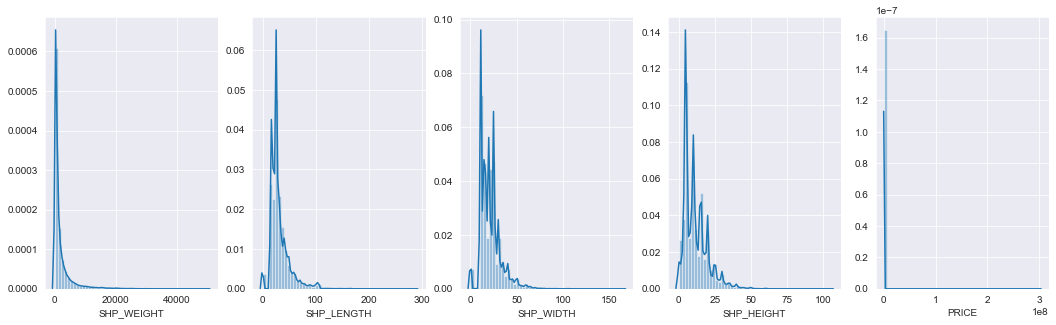

In [29]:
#Verifico tamaño
f, axes = plt.subplots(1, 5, figsize=(18, 5))

g = sns.distplot(df.SHP_WEIGHT.dropna(),ax=axes[0])
g = sns.distplot(df.SHP_LENGTH.dropna(), ax=axes[1])
g = sns.distplot(df.SHP_WIDTH.dropna(), ax=axes[2])
g = sns.distplot(df.SHP_HEIGHT.dropna(),ax=axes[3])
g = sns.distplot(df.PRICE.dropna(), ax=axes[4])

Veamos cuales son los envios de mayor dimensiones para saber si es una mala entrada o realmente esos son los valores correctos

In [30]:
df[(df.SHP_LENGTH > 120)].sort_values('SHP_LENGTH', ascending=False).head(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row
79001,TV02XTLWW7,1520.0,288.2,33.9,5.2,"[{'id': 'PART_LOCATION', 'name': 'Localização'...",H53U1H7Q5G,new,MLB-AUTOMOTIVE_DEFLECTORS,79.00,VQ3HFM2YHB,paused,Calha Defletor Chuva Peugeot 206 207 Sw Escapa...,True,False,True,True,0
86969,MAMD9GV7ZZ,5940.0,275.0,10.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PHOTOGRAPHY_BACKDROPS,450.00,R4CK5CVOTR,active,"Fundo Fotográfico Papel Cinza Graystone 2,70 X...",True,False,True,True,0
372351,DJT34F0C9Y,1390.0,250.0,11.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-LIGHT_BULBS,34.97,ZF9SGFY354,active,Calha/suporte T8 Duplo Para Lampada Led Tubula...,True,False,True,True,0
418815,Q1H1P8CLMD,5680.0,248.0,20.0,13.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-LIGHT_BULBS,323.50,FSL25ZACM2,paused,Kit 5 Led Ho Tubular 240cm Branco Frio Cristal...,True,False,True,True,0
369429,KNE0QU7O5X,8410.0,247.0,19.0,17.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-LIGHT_BULBS,353.30,FSL25ZACM2,active,Kit 10 Luminária Led Tubular 120cm Bivolt Bran...,True,False,True,True,0


Por lo que podemos ver los articulos de los envios poseen grandes dimensiones, por ende no quitaremos ningun valor del dataset. Si podemos ver valores fuera de escala en el peso y el precio de los envios. Calcularemos analiticamente los valores teoricos a partir de los cuales las entradas se consideraran outliers.

In [31]:
Q1 = df[df.HAS_DIM][var_cont].quantile(1/4)
Q3 = df[df.HAS_DIM][var_cont].quantile(3/4)
IQR = Q3 - Q1
l_inf = Q1 - 3*IQR
l_sup = Q3 + 3*IQR

In [32]:
l_sup

SHP_WEIGHT    7030.0
SHP_LENGTH      88.0
SHP_WIDTH       58.0
SHP_HEIGHT      49.0
PRICE          572.6
dtype: float64

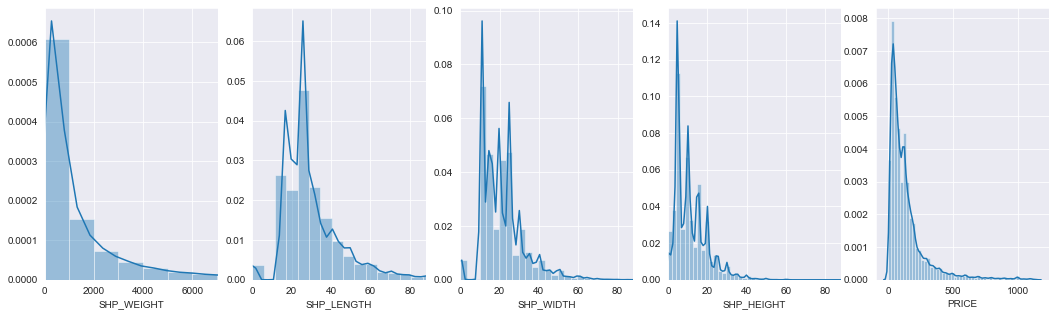

In [33]:
#Verifico tamaño
f, axes = plt.subplots(1, 5, figsize=(18, 5))

g = sns.distplot(df.SHP_WEIGHT.dropna(), ax=axes[0]).set(xlim=(0, l_sup[0]))
g = sns.distplot(df.SHP_LENGTH.dropna(), ax=axes[1]).set(xlim=(0, l_sup[1]))
g = sns.distplot(df.SHP_WIDTH.dropna(), ax=axes[2]).set(xlim=(0, l_sup[1]))
g = sns.distplot(df.SHP_HEIGHT.dropna(), ax=axes[3]).set(xlim=(0, l_sup[1]))
# Utilizaremos un limite del doble del limite del outlier
g = sns.distplot(df.PRICE.dropna()[df.PRICE < 1146], ax=axes[4])

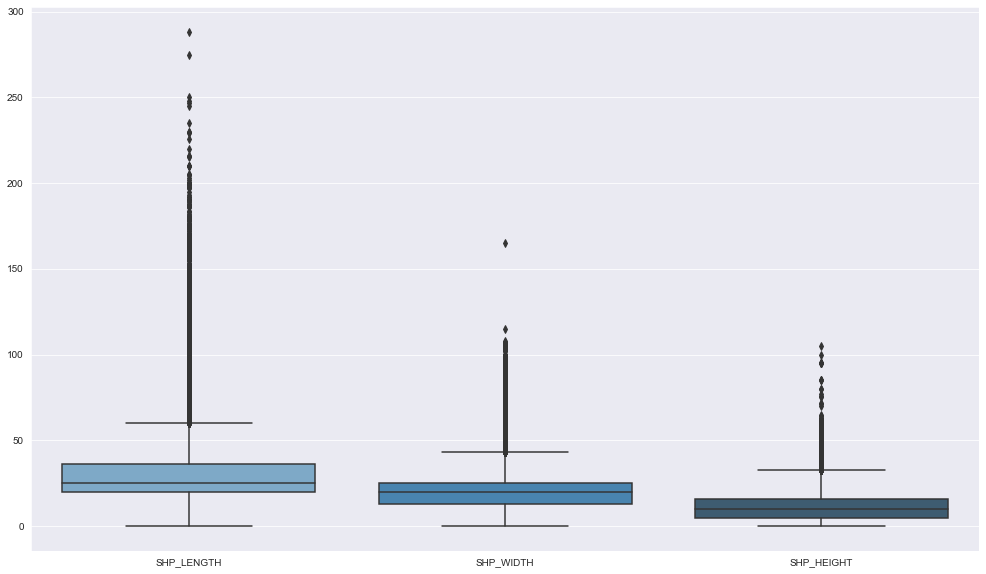

In [34]:
f, axes = plt.subplots(1, 1, figsize=(17,10))

pal = sns.color_palette("Blues_d", 3)

g = sns.boxplot(data=df[['SHP_LENGTH','SHP_WIDTH','SHP_HEIGHT']],palette=np.array(pal[::-1]),ax=axes)

# Relacion entre variables, Correlacion e Independencia

A continuacion queremos analizar como se relacionan las variables del dataset. Nuestro objetivo es la deteccion de paquetes cuyas dimensiones requieran manipulacion de personal. Consultando la documentacion del correo dicho valor es de 70 cm. Analizando los datos de dimensiones podemos ver que la dimension mayor siempre es la que se encuentra en SHP_LENGTH, por lo tanto sera nuestro valor de salida.

Comenzaremos filtrando el dataset a los valores que poseen dimensiones validas, y adicionando una variable que nos indique si el envio recibio multa o no.

In [35]:
df['EXCEDIDO'] = df.SHP_LENGTH > 70

### Correlacion con variables numericas ###

Adicionalmente a las dimensiones, tenemos 2 variables numericas mas que son precio y peso. Adicionaremos algunas variables para ampliar el analisis.

In [36]:
df_dim = df[df.HAS_DIM]

In [37]:
df_dim['VOLUME'] = df_dim.SHP_HEIGHT * df_dim.SHP_LENGTH * df_dim.SHP_WIDTH
df_dim['DENSITY'] = df_dim.VOLUME / df_dim.SHP_WEIGHT

In [38]:
df_dim.shape

(340266, 21)

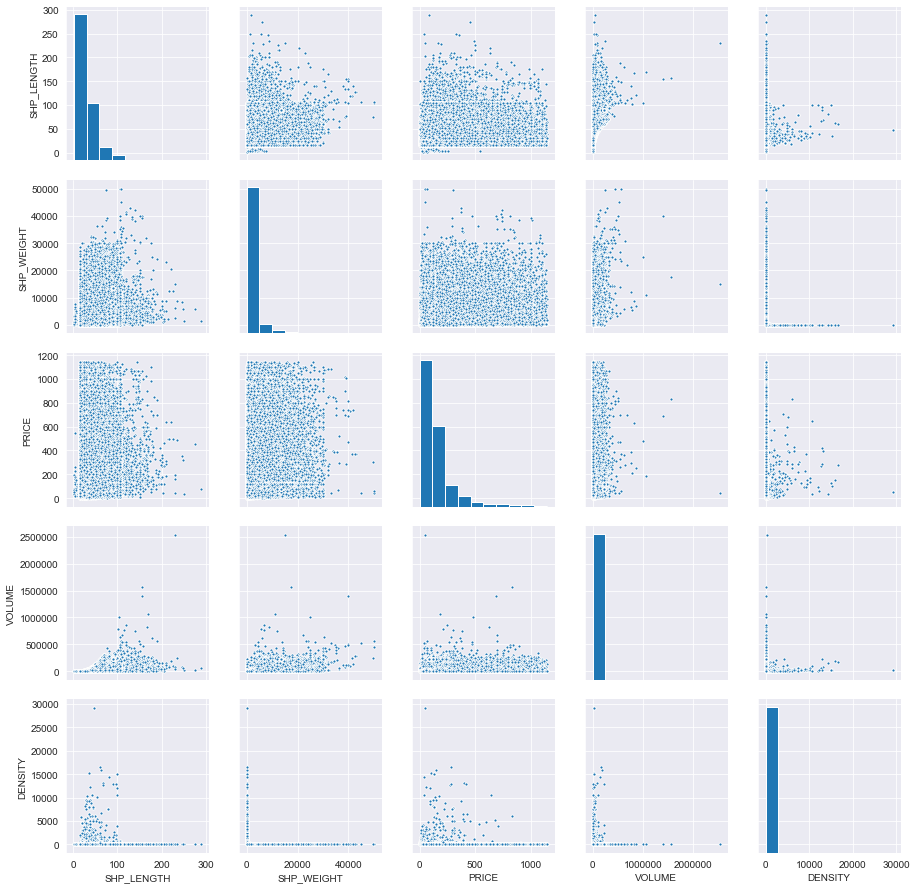

In [39]:
sns.pairplot(
    data=df_dim[df_dim.PRICE < 1146],
    vars=['SHP_LENGTH','SHP_WEIGHT', 'PRICE','VOLUME','DENSITY'],
    markers='.')

Realmente no se pueden apreciar correlaciones importantes entre las variables numericas

## Correlacion con variables categoricas

Empezaremos analisando las diferentes categorias de DOMAIN_ID, dado la gran cantidad de categorias restringimos el analisis a aquellas que poseen una poblacion de mas de 30 elementos de modo que sus estadisticos sean validos.


In [40]:
df_dom = df_dim[df.IS_SIG_DOM]
df_dom.shape

C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(244820, 21)

### 10 Categorias mas grandes

In [41]:
df_gr = df_dom.groupby('DOMAIN_ID').mean().sort_values('SHP_LENGTH', ascending=False)

df_larger = df_gr.head(10)
df_larger

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
DOMAIN_ID,,,,,,,,,,,,,
MLB-PICKUP_TRUCK_BED_COVERS,6785.333333,165.420000,20.540000,14.772000,322.162000,1.0,0.000000,1.0,1.0,0,1.000000,50242.802440,7.433380
MLB-BRUSH_CUTTERS,9176.444444,158.520000,36.806667,29.762222,690.284889,1.0,0.000000,1.0,1.0,0,1.000000,181920.903022,252.634051
MLB-STRING_TRIMMERS,2946.779661,111.766102,24.320339,11.937288,185.969322,1.0,0.000000,1.0,1.0,0,0.864407,33837.491492,11.710380
MLB-ROOF_RACKS,4364.137255,111.526144,19.003922,12.201307,299.133660,1.0,0.000000,1.0,1.0,0,0.954248,28590.568425,6.443556
MLB-BICYCLES,12350.041475,106.850230,58.199078,22.463594,640.946498,1.0,0.000000,1.0,1.0,0,0.585253,158060.039631,11.945961
MLB-ELECTRIC_GUITARS,4905.000000,105.880000,42.000000,14.926667,989.413667,1.0,0.000000,1.0,1.0,0,1.000000,67476.593200,13.715480
MLB-LADDERS,11641.808511,103.534043,39.098936,26.487234,306.776277,1.0,0.404255,1.0,1.0,0,1.000000,105954.241000,9.743179
MLB-AUTOMOTIVE_FENDERS,4571.707317,102.980488,66.985366,20.100000,251.887073,1.0,0.000000,1.0,1.0,0,0.926829,154373.586317,38.317459
MLB-ACOUSTIC_GUITARS,3153.404908,101.705521,44.769325,15.396933,591.943497,1.0,0.000000,1.0,1.0,0,0.963190,72145.756055,24.115475


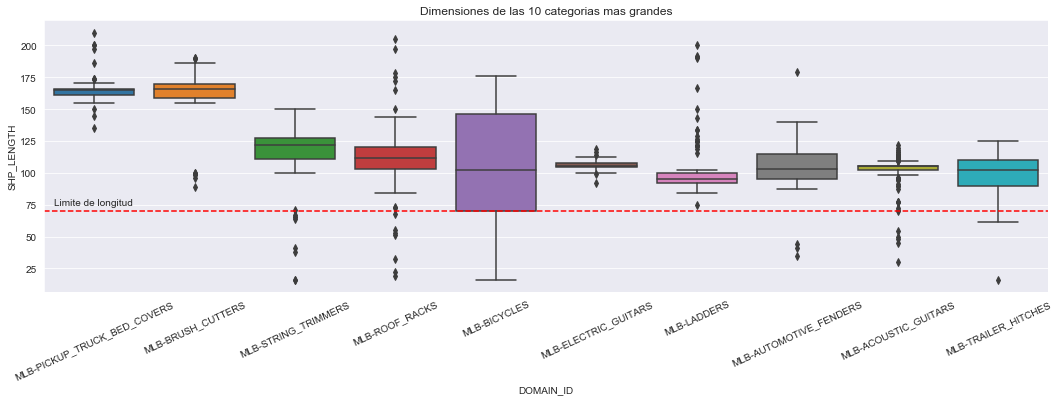

In [42]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.boxplot(x= 'DOMAIN_ID', y= 'SHP_LENGTH', data = df_dom[df_dom.DOMAIN_ID.isin(df_larger.index)], order= df_larger.index)
g = plt.title('Dimensiones de las 10 categorias mas grandes')
g = plt.xticks(rotation=25)

g = axes.axhline(70, ls='--', color='red')
g = axes.text(-0.4, 75, "Limite de longitud")

### 10 Categorias con mas valores excedidos

In [43]:
df_gr.sort_values('EXCEDIDO', ascending=False, inplace=True)
df_excedidos = df_gr.head(10)
df_excedidos

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
DOMAIN_ID,,,,,,,,,,,,,
MLB-PICKUP_TRUCK_BED_COVERS,6785.333333,165.420000,20.540000,14.772000,322.162000,1.0,0.000000,1.0,1.0,0,1.000000,50242.802440,7.433380
MLB-BRUSH_CUTTERS,9176.444444,158.520000,36.806667,29.762222,690.284889,1.0,0.000000,1.0,1.0,0,1.000000,181920.903022,252.634051
MLB-ELECTRIC_GUITARS,4905.000000,105.880000,42.000000,14.926667,989.413667,1.0,0.000000,1.0,1.0,0,1.000000,67476.593200,13.715480
MLB-LADDERS,11641.808511,103.534043,39.098936,26.487234,306.776277,1.0,0.404255,1.0,1.0,0,1.000000,105954.241000,9.743179
MLB-MASSAGE_TABLES,15839.565217,93.021739,67.695652,19.130435,480.874348,1.0,0.000000,1.0,1.0,0,1.000000,126624.565217,8.038492
MLB-TRAILER_HITCHES,10276.095238,99.334921,49.250794,20.153968,304.410794,1.0,0.000000,1.0,1.0,0,0.968254,104884.641667,10.460104
MLB-ACOUSTIC_GUITARS,3153.404908,101.705521,44.769325,15.396933,591.943497,1.0,0.000000,1.0,1.0,0,0.963190,72145.756055,24.115475
MLB-ROOF_RACKS,4364.137255,111.526144,19.003922,12.201307,299.133660,1.0,0.000000,1.0,1.0,0,0.954248,28590.568425,6.443556
MLB-GAZEBOS,8101.775862,98.568103,20.767241,18.867241,464.653103,1.0,0.000000,1.0,1.0,0,0.939655,42407.061733,5.496431


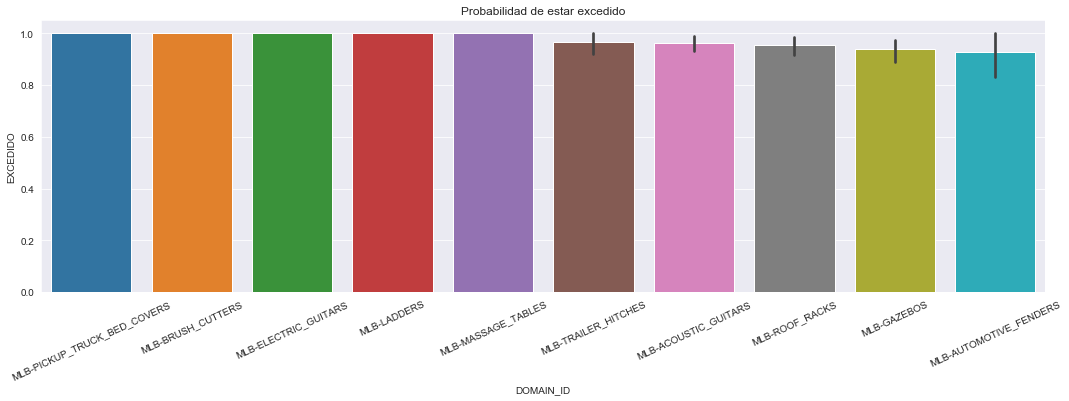

In [44]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.barplot(x= 'DOMAIN_ID', y= 'EXCEDIDO', data = df_dom[df_dom.DOMAIN_ID.isin(df_excedidos.index)], order= df_excedidos.index)
g = plt.title('Probabilidad de estar excedido')
g = plt.xticks(rotation=25)

Claramente podemos ver que existen categorias con alta probabilidad de excederse en las dimensiones permitidas. A partir de aqui ya podemos definir un limite de probabilidad y excluir de la plataforma de envios todas las categorias que lo sobrepasen.

In [45]:
prob_exceso_max = 0.3
banned_DOMAINS = df_gr[df_gr.EXCEDIDO > prob_exceso_max].index
banned_DOMAINS

Index(['MLB-PICKUP_TRUCK_BED_COVERS', 'MLB-BRUSH_CUTTERS',
       'MLB-ELECTRIC_GUITARS', 'MLB-LADDERS', 'MLB-MASSAGE_TABLES',
       'MLB-TRAILER_HITCHES', 'MLB-ACOUSTIC_GUITARS', 'MLB-ROOF_RACKS',
       'MLB-GAZEBOS', 'MLB-AUTOMOTIVE_FENDERS', 'MLB-VIOLINS',
       'MLB-BABY_STROLLERS', 'MLB-CAR_DEFLECTORS', 'MLB-STRING_TRIMMERS',
       'MLB-BICYCLE_FRAMES', 'MLB-KITCHEN_CABINETS',
       'MLB-AUTOMOTIVE_TRUNK_CARGO_COVER_SHIELDS', 'MLB-BICYCLE_FORKS',
       'MLB-DOOR_AND_STAIR_SAFETY_FENCES', 'MLB-FISHING_RODS',
       'MLB-KITCHEN_RANGE_HOODS', 'MLB-BASEBALL_AND_SOFTBALL_BATS',
       'MLB-RUBBER_FLOORS', 'MLB-AUTOMOTIVE_DEFLECTORS', 'MLB-BABY_PLAYARDS',
       'MLB-BABY_BATHTUBS', 'MLB-POOL_WATERFALLS', 'MLB-OFFICE_CHAIRS',
       'MLB-STOOLS', 'MLB-SKATEBOARDS', 'MLB-CAMPING_CHAIRS',
       'MLB-CLOTHING_RACKS', 'MLB-TELEVISIONS', 'MLB-OUTDOOR_TABLES',
       'MLB-BICYCLES', 'MLB-POUFS', 'MLB-MICROPHONE_STANDS',
       'MLB-RACKS_AND_PINIONS', 'MLB-CELLPHONE_SIGNAL_BOOSTER_ANT

### 10 Categorias mas chicas

In [46]:
df_gr.sort_values('SHP_LENGTH', inplace=True)
df_smaller = df_gr.head(10)
df_smaller

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
DOMAIN_ID,,,,,,,,,,,,,
MLB-AUTOMOTIVE_SPEED_SENSORS,181.388889,16.916667,12.272222,8.002778,74.546389,1.0,0.000000,1.0,1.0,0,0.0,1761.930639,12.652773
MLB-NAIL_RHINESTONES,328.181818,16.990909,11.900000,5.390909,99.820364,1.0,0.000000,1.0,1.0,0,0.0,1146.877273,7.275584
MLB-MAF_SENSORS,302.264706,17.529412,13.823529,8.705882,182.910882,1.0,0.000000,1.0,1.0,0,0.0,2448.588235,10.497164
MLB-MOTORCYCLE_GASOLINE_TANK_CAPS,381.142857,17.571429,14.750000,12.571429,68.745714,1.0,0.000000,1.0,1.0,0,0.0,3347.571429,12.898468
MLB-CELLPHONE_LCD_SCREENS,173.310816,17.949072,14.596080,7.054253,117.515961,1.0,0.000000,1.0,1.0,0,0.0,2232.844592,14.145421
MLB-ABS_SENSORS,220.716667,17.953333,12.746667,8.266667,117.699333,1.0,0.000000,1.0,1.0,0,0.0,2066.321333,19.735139
MLB-DIGITAL_VOICE_RECORDERS,195.513514,18.135135,14.486486,6.621622,146.067838,1.0,0.000000,1.0,1.0,0,0.0,2073.810811,12.664230
MLB-UNIVERSAL_CAR_REMOTES,248.783217,18.136783,13.242727,9.134965,83.963077,1.0,0.000000,1.0,1.0,0,0.0,2721.263103,13.031929
MLB-DEFENSE_KNUCKLES,283.973684,18.157895,12.684211,5.894737,111.138947,1.0,0.000000,1.0,1.0,0,0.0,1514.342105,8.098896


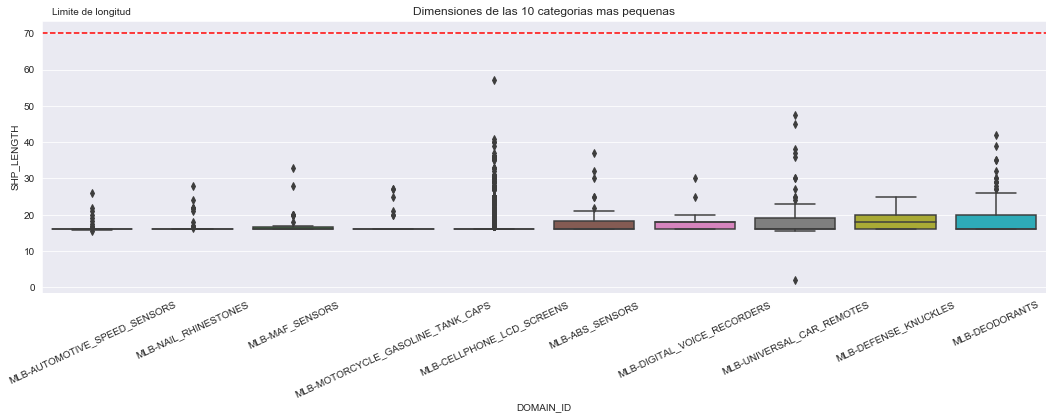

In [47]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.boxplot(x= 'DOMAIN_ID', y= 'SHP_LENGTH', data = df_dom[df_dom.DOMAIN_ID.isin(df_smaller.index)], order= df_smaller.index)
g = plt.title('Dimensiones de las 10 categorias mas pequenas')
g = plt.xticks(rotation=25)

g = axes.axhline(70, ls='--', color='red')
g = axes.text(-0.4, 75, "Limite de longitud")

Como era esperable y por el contrario del caso anterior podemos ver que ninguna de estas categorias sobrepasa los limites permitidos de envio.

### 10 Categorias con mas variacion

In [48]:
df_gr = df_dom.groupby('DOMAIN_ID').std().sort_values('SHP_LENGTH', ascending=False)

df_high_std = df_gr.head(10)
df_high_std

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
DOMAIN_ID,,,,,,,,,,,,,
MLB-PHOTOGRAPHY_BACKDROPS,2402.547450,40.584876,4.241579,2.344568,355.022312,0.0,0.0,0.0,0.0,0.0,0.164399,3508.514612,9.888111
MLB-GARDENING,5429.788043,40.533181,13.213902,9.179390,639.932535,0.0,0.0,0.0,0.0,0.0,0.429656,52853.540992,17.581061
MLB-AUTOMOTIVE_BUMPER_BRACKETS,4305.774932,38.954676,17.789288,9.704208,1017.478952,0.0,0.0,0.0,0.0,0.0,0.429070,57509.204414,12.198109
MLB-BICYCLES,7005.095877,38.246120,20.742875,5.617484,469.095951,0.0,0.0,0.0,0.0,0.0,0.493817,99277.081939,3.040803
MLB-FISHING_REELS,715.660326,37.834411,7.647517,5.601077,433.809001,0.0,0.0,0.0,0.0,0.0,0.492174,18018.329395,16.533798
MLB-VINYL_ROLLS,898.170868,36.881469,10.517435,4.872266,58.423682,0.0,0.0,0.0,0.0,0.0,0.484778,12199.758295,27.188618
MLB-PARTY_DECORATIVE_BACKDROPS,3377.270028,36.169530,15.968428,9.231139,122.285040,0.0,0.0,0.0,0.0,0.0,0.500748,22907.160226,15.460891
MLB-AUTOMOTIVE_MUFFLERS,3627.191314,35.172955,14.275288,8.154174,111.988808,0.0,0.0,0.0,0.0,0.0,0.497867,41525.774495,6.222229
MLB-BED_AND_CRIB_SAFETY_RAILS,1793.391833,34.935339,13.376460,3.552300,66.246099,0.0,0.0,0.0,0.0,0.0,0.504685,18319.610428,6.905596


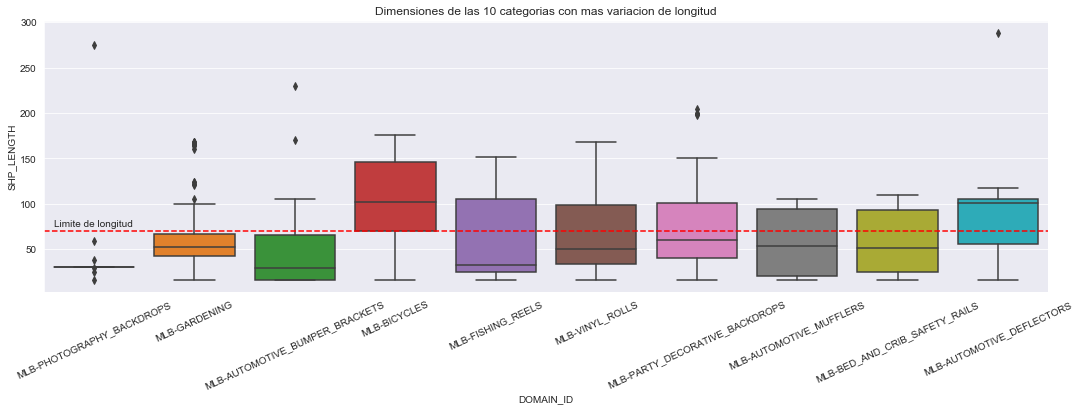

In [49]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.boxplot(x= 'DOMAIN_ID', y= 'SHP_LENGTH', data = df_dom[df_dom.DOMAIN_ID.isin(df_high_std.index)], order= df_high_std.index)
g = plt.title('Dimensiones de las 10 categorias con mas variacion de longitud')
g = plt.xticks(rotation=25)

g = axes.axhline(70, ls='--', color='red')
g = axes.text(-0.4, 75, "Limite de longitud")

### 10 Categorias con menos variacion

In [50]:
df_gr.sort_values('SHP_LENGTH', inplace=True)
df_low_std = df_gr.head(10)
df_low_std

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
DOMAIN_ID,,,,,,,,,,,,,
MLB-MAKEUP_SPONGES,266.918625,1.290994,3.692979,3.681356,51.895761,0.0,0.0,0.0,0.0,0.0,0.0,2651.519915,84.513453
MLB-NIGHTGOWNS,515.730569,1.552309,3.286041,2.859006,53.345292,0.0,0.0,0.0,0.0,0.0,0.0,1614.133989,8.891315
MLB-BICYCLE_REAR_DERAILLEURS,326.051558,1.750604,3.323575,4.466112,320.440049,0.0,0.0,0.0,0.0,0.0,0.0,2126.261715,57.605387
MLB-E_READERS,99.668759,2.079709,1.568207,2.143358,118.853301,0.0,0.0,0.0,0.0,0.0,0.0,743.665643,13.579906
MLB-AUTOMOTIVE_SPEED_SENSORS,122.736949,2.176826,2.157195,3.188146,49.291462,0.0,0.0,0.0,0.0,0.0,0.0,1226.847930,9.552845
MLB-DEFENSE_KNUCKLES,243.894360,2.331063,2.132189,2.758667,473.291525,0.0,0.0,0.0,0.0,0.0,0.0,1132.487057,6.966102
MLB-CAJONS,887.864850,2.357667,2.163934,3.999547,161.731236,0.0,0.0,0.0,0.0,0.0,0.0,10792.726456,2.035381
MLB-BICYCLE_PEDALS,370.752444,2.388833,2.770311,2.434342,144.580849,0.0,0.0,0.0,0.0,0.0,0.0,974.184760,1.852404
MLB-NAIL_RHINESTONES,300.998529,2.472985,1.956471,1.483523,146.071006,0.0,0.0,0.0,0.0,0.0,0.0,712.521770,6.236177


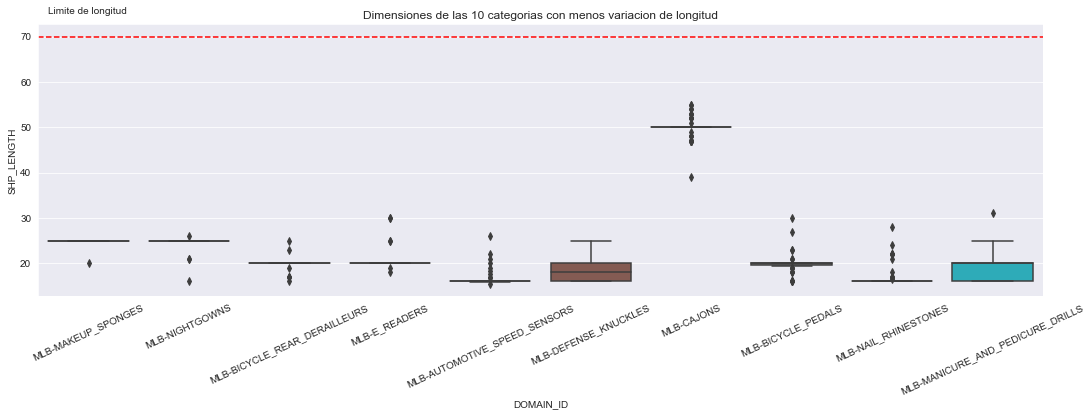

In [51]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.boxplot(x= 'DOMAIN_ID', y= 'SHP_LENGTH', data = df_dom[df_dom.DOMAIN_ID.isin(df_low_std.index)], order= df_low_std.index)
g = plt.title('Dimensiones de las 10 categorias con menos variacion de longitud')
g = plt.xticks(rotation=25)

g = axes.axhline(70, ls='--', color='red')
g = axes.text(-0.4, 75, "Limite de longitud")

## Distribucion en base a CONDITION

In [52]:
df_gr = df_dim.groupby('CONDITION').mean().sort_values('SHP_LENGTH', ascending=False)
df_gr

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
CONDITION,,,,,,,,,,,,,
new,1956.412390,32.605065,22.076021,12.026317,1648.905860,1.0,0.007593,0.955001,1.0,0.002399,0.049025,14685.933828,18.120702
used,2114.391784,30.641583,20.394389,11.678257,280.447936,1.0,0.000000,0.875752,1.0,0.049098,0.032064,12719.630775,14.362097
not_specified,1326.265487,29.172271,20.221829,11.443068,210.425221,1.0,0.000000,0.917404,1.0,0.011799,0.017699,9796.542944,21.471915


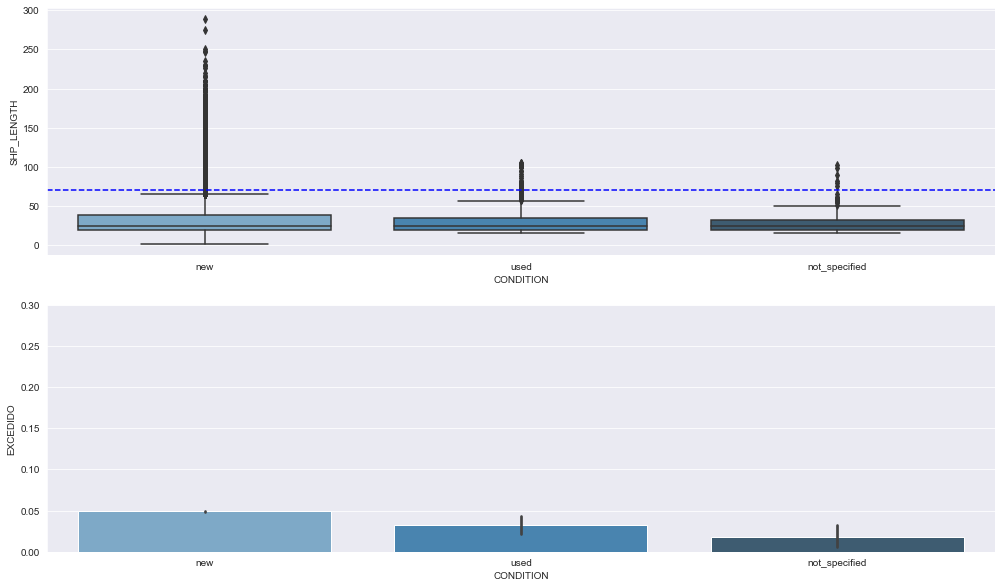

In [53]:
f, axes = plt.subplots(2, 1, figsize=(17,10))

pal = sns.color_palette("Blues_d", 3)


g = sns.boxplot(x= 'CONDITION', y= 'SHP_LENGTH', data = df_dim , ax=axes[0], palette=np.array(pal[::-1]))
g = axes[0].axhline(70, ls='--', color='blue')

g = sns.barplot(x= 'CONDITION', y= 'EXCEDIDO', data = df_dim  , ax=axes[1],palette=np.array(pal[::-1])).set(ylim=(0,0.3)) 

#### Test de Independencia, Chi2
Consideremos un valor de significancia del 0.05 (95%)

In [54]:
contingency = pd.crosstab(df_dim['EXCEDIDO'], df_dim['CONDITION'])
contingency

CONDITION,new,not_specified,used
EXCEDIDO,,,
False,242608,333,966
True,12507,6,32


In [55]:
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(contingency)
chi2, p

(13.257470460040938, 0.001321833844999967)

Vemos que el valor de p-value es notablemente menor que nuestro nivel requerido, por lo tanto refutamos la hipotesis de independencia y podemos decir que la variable CONDITION esta correlacionado a la probabilidad de tener exceso de tamaño.

## Distribucion en base al estado de la publicacion, STATUS

In [56]:
df_gr = df_dim.groupby('STATUS').mean().sort_values('SHP_LENGTH', ascending=False)
df_gr

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY
STATUS,,,,,,,,,,,,,
closed,2248.342331,34.678480,22.609932,12.207325,827.568410,1.0,0.009901,0.916367,1.0,0.065601,0.085735,17429.843628,18.380001
active,1924.172306,32.496630,22.167968,12.023517,2202.245621,1.0,0.008882,0.956930,1.0,0.000241,0.044552,14283.497630,17.366226
404,1857.341983,32.387269,21.657090,11.963120,NaN,1.0,0.006178,0.000000,1.0,6.000000,0.033064,13674.088153,15.505924
paused,1951.971499,32.304855,21.739172,11.980872,723.929859,1.0,0.004405,0.956685,1.0,0.001700,0.049234,14804.889127,19.550840
inactive,1354.212500,28.453615,19.696655,10.174527,NaN,1.0,0.006757,0.000000,1.0,4.000000,0.017230,9093.083326,12.433129
under_review,1427.740862,28.337804,19.552854,10.184019,NaN,1.0,0.010654,0.000000,1.0,4.000000,0.023111,9942.147555,13.748548


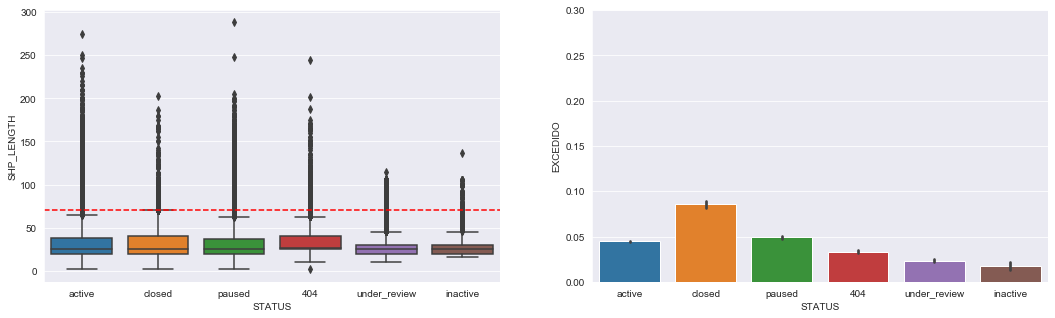

In [57]:
f, axes = plt.subplots(1, 2, figsize=(18, 5))

g = sns.boxplot(x= 'STATUS', y= 'SHP_LENGTH', data = df_dim , ax=axes[0])
g = axes[0].axhline(70, ls='--', color='red')

g = sns.barplot(x= 'STATUS', y= 'EXCEDIDO', data = df_dim  , ax=axes[1]).set(ylim=(0,0.3))

#### Test de Independencia, Chi2
Consideremos un valor de significancia del 0.05 (95%)

In [58]:
contingency = pd.crosstab(df_dim['EXCEDIDO'], df_dim['STATUS'])
contingency

STATUS,404,active,closed,inactive,paused,under_review
EXCEDIDO,,,,,,
False,48516,150915,16529,2909,76627,29800
True,1659,7037,1550,51,3968,705


In [59]:
chi2, p, dof, ex = chi2_contingency(contingency)
chi2, p

(1311.9129906235878, 1.676419914231013e-281)

Vemos que el valor de p-value es notablemente menor que nuestro nivel requerido, por lo tanto refutamos la hipotesis de independencia y podemos decir que el Status esta correlacionado a la probabilidad de tener exceso de tamano.

## Analisis y Correlacion con variable tipo documento, ATTRIBUTES
La informacion de atributos no esta directamente disponible, debemos primero limpiar y obtener los valores utiles de formato JSON lines.

In [60]:
att_list = []
for i, att in enumerate(df_dim.ATTRIBUTES):    
    if type(att) != float:
        att_list.append(ast.literal_eval(att))
    else:
        att_list.append([])
        
att_dict = [{att['id'] : att['value_name']  for att in item_att_list} for item_att_list in att_list ]

In [61]:
df_dim['N_ATTBS'] = [len(a) for a in att_list]

Dado que existen gran cantidad de atributos, buscaremos cuales son los principales en termino de frecuencia.

In [62]:
att_count_dict = {}

for att in att_dict:
    for att_id in att:
        if att_id in att_count_dict:
            att_count_dict[att_id] += 1
        else:
            att_count_dict[att_id] = 1

In [63]:
sorted_att_count = sorted(att_count_dict.items(), key=lambda x: x[1], reverse=True)

In [64]:
sorted_att_count[:10]

[('ITEM_CONDITION', 255771),
 ('BRAND', 230666),
 ('MODEL', 188127),
 ('GTIN', 96228),
 ('EAN', 60236),
 ('SELLER_SKU', 47193),
 ('GENDER', 34242),
 ('LINE', 33809),
 ('IS_KIT', 25532),
 ('PART_NUMBER', 23006)]

Seleccionamos BRAND y MODEL para adicionar como variables de analisis, ya que otros ya estan en el dataset (CONDITION, SELLER) o son simplemente identificadores de producto (GTIN, EAN)

In [65]:
var_to_add = ['BRAND', 'MODEL']

for var in var_to_add:
    df_dim[var] = [item_att_dict[var] if var in item_att_dict else '' for item_att_dict in att_dict]   

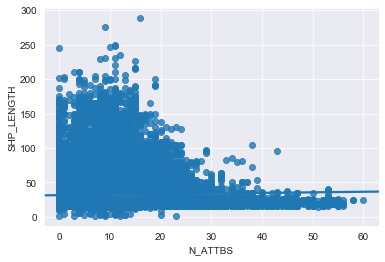

In [66]:
g = sns.regplot('N_ATTBS', 'SHP_LENGTH', data=df_dim)

En este caso no observamos una correlacion significativa.

### Analisis en base a la marca, atributo BRAND

In [67]:
sig_brands = (df_dim.BRAND.value_counts()>30)
sig_brand_id = sig_brands[sig_brands].index
df_brand = df_dim[df_dim.BRAND.isin(sig_brand_id)]

In [68]:
df_gr = df_brand.groupby('BRAND').mean().sort_values('SHP_LENGTH', ascending=False)
df_gr.head(10)

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,HAS_DIM,IS_SIG_ITEM,IS_SIG_DOM,IS_RECO,n_nas_row,EXCEDIDO,VOLUME,DENSITY,N_ATTBS
BRAND,,,,,,,,,,,,,,
Capota Marítima,6716.133333,164.432000,20.556000,14.858667,317.377200,1.0,0.00000,1.000000,1.0,0.0,1.000000,50272.833293,7.511231,7.240000
Alfameq,17005.490196,145.637255,76.200000,21.364706,953.104902,1.0,0.00000,1.000000,1.0,0.0,1.000000,237367.070588,14.094540,13.549020
Rotterman,10759.877551,105.591837,39.804082,25.869388,244.028571,1.0,0.77551,1.000000,1.0,0.0,0.979592,103735.041796,11.015607,18.326531
Engate Reboque,9599.838710,100.096774,45.193548,19.645161,275.378387,1.0,0.00000,1.000000,1.0,0.0,0.967742,96846.516129,10.875479,4.935484
Santa Fé Macas,19600.000000,93.764935,71.454545,19.233766,370.893766,1.0,0.00000,1.000000,1.0,0.0,0.935065,144110.681688,7.339561,4.948052
Trapp,5245.250000,92.485417,27.218750,17.000000,338.276250,1.0,0.00000,0.812500,1.0,0.0,0.666667,46550.295958,15.564868,8.770833
Botafogo,8913.878049,92.065854,34.743902,21.258537,228.810488,1.0,0.00000,0.780488,1.0,0.0,0.707317,80307.611829,9.539704,11.341463
Itagold,11971.169492,84.847458,60.254237,36.737288,179.585339,1.0,0.00000,0.906780,1.0,0.0,0.898305,204277.813559,16.517794,10.677966
Tagima,3593.220588,84.697059,34.798529,13.476471,615.374412,1.0,0.00000,0.970588,1.0,0.0,0.676471,52785.968618,16.642153,9.867647


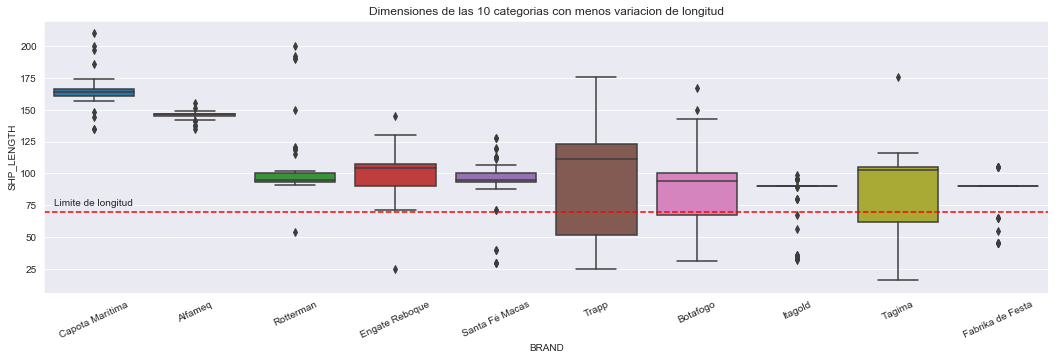

In [69]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.boxplot(x= 'BRAND', y= 'SHP_LENGTH', data = df_brand[df_brand.BRAND.isin(df_gr.head(10).index)], order= df_gr.head(10).index)
g = plt.title('Dimensiones de las 10 categorias con menos variacion de longitud')
g = plt.xticks(rotation=25)

g = axes.axhline(70, ls='--', color='red')
g = axes.text(-0.4, 75, "Limite de longitud")

In [70]:
df_gr.sort_values('EXCEDIDO', ascending=False, inplace= True)

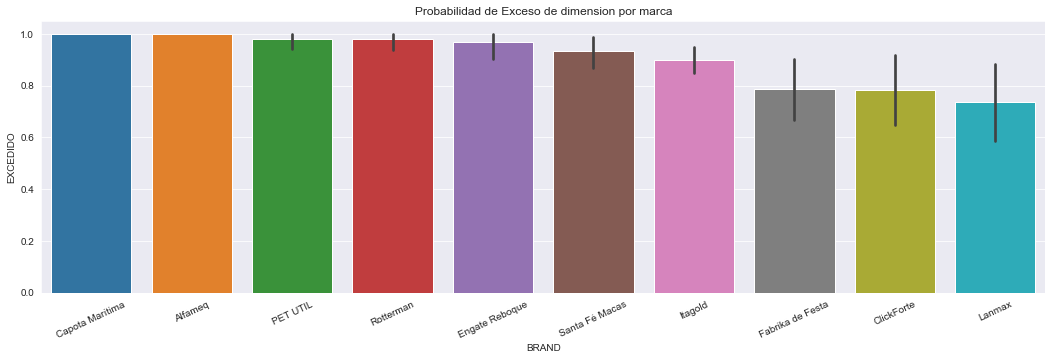

In [71]:
f, axes = plt.subplots(1, 1, figsize=(18, 5))
g = sns.barplot(x= 'BRAND', y= 'EXCEDIDO', data = df_brand[df_brand.BRAND.isin(df_gr.head(10).index)], order= df_gr.head(10).index)
g = plt.title('Probabilidad de Exceso de dimension por marca')
g = plt.xticks(rotation=25)

In [72]:
banned_BRANDS = df_gr[df_gr.EXCEDIDO > 0.3].index
banned_BRANDS

Index(['Capota Marítima', 'Alfameq', 'PET UTIL', 'Rotterman', 'Engate Reboque',
       'Santa Fé Macas', 'Itagold', 'Fabrika de Festa', 'ClickForte', 'Lanmax',
       'MEGA PUFF', 'Botafogo', 'Giannini', 'Tagima', 'Trapp', 'FORTUNA',
       'Ottoni', 'Village', 'Bel Fix', 'Color Baby', 'Galzerano', 'KELAN',
       'QGK', 'Burigotto', 'Slim', 'Cortag', 'Tander', 'MARIA', 'Universais',
       'Marine Sports', 'Imprimax', 'Maruri', 'VHIP', 'MOR',
       'CIKALA DISTRIBUIÇÃO', 'CBC', 'Tutti Baby', 'Calesita', 'Secalux',
       'Rossi', 'Marchesoni', 'RCG', 'DIVERSOS', 'Baby Style', 'Mor',
       'JJVERAS', 'Plasmaq', 'Tssaper', 'Blawer', 'Greika'],
      dtype='object', name='BRAND')

Podemos volver a repetir el analisis para MODEL.

## Analisis de correlacion con respecto al titulo de la publicacion

Comenzamos haciendo una cuenta de las palabras mas comunes

In [73]:
from collections import Counter

In [74]:
title_tk = df_dim.TITLE.str.lower().str.split()

In [75]:
df_title = df_dim[['EXCEDIDO','SHP_LENGTH']]
df_title['TITLE_TK'] = title_tk
df_title.dropna(inplace=True)

In [76]:
c = Counter()
title_tk.dropna().apply(c.update);
c.most_common()[:10]

[('de', 60439),
 ('kit', 46454),
 ('-', 42209),
 ('+', 34167),
 ('com', 21194),
 ('para', 20342),
 ('e', 19532),
 ('original', 19256),
 ('2', 15546),
 ('3', 10982)]

Vemos que las mas frecuentes son palabras conectoras o simbolos, tambien llamadas stopwords. Dado que no proveen informacion cargamos un archivo con stopwords de portugues y le adicionamos algunos simbolos comunes de modo de retirarlas de nuestro analisis.

In [79]:
stop_words = []
with open('stopwords.txt', "r") as f:
    for line in f:
        stop_words.extend(line.split())

simbols = list('123456789-+/*aeiou') + ['10','c/','p/']

In [80]:
for word in stop_words + simbols:
    if word in c:
        del c[word]

In [81]:
c = pd.Series(c).sort_values(ascending=False)

In [82]:
common_words = c[c > 1000]
common_words[:10]

kit         46454
original    19256
led          9405
tela         7576
capa         6856
preto        6483
frete        6001
promoção     5937
usb          5833
moto         5710
dtype: int64

Vemos que ahora tenemos palabras significativas. Dado que tenemos un gran numero de palabras restringiremos el analisis a las de mayor frecuencia de aparicion. Con tiempo y paciencia se puede extender para todo el vocabulario

In [83]:
len(common_words)

332

Para ver si las palabras tienen significancia estadistica realizaremos un test chi2

In [84]:
df_gr = pd.DataFrame(columns=['EXCEDIDO','SHP_LENGTH'])
contingency = pd.DataFrame(columns=['EXCEDIDO','CORRECTO'])

for word in common_words.index:
    has_word = df_title.TITLE_TK.apply(lambda x: word in x)
    
    n_excedido = df_title.EXCEDIDO[has_word].sum()
    n_no_excedido = len(has_word) - n_excedido
    contingency.loc[word] = [n_excedido, n_no_excedido]
    
    df_gr.loc[word] = df_title[['EXCEDIDO','SHP_LENGTH']][has_word].mean()

In [88]:
contingency.head(5)

,EXCEDIDO,CORRECTO
kit,2376,287715
original,328,289763
led,470,289621
tela,94,289997
capa,174,289917


In [89]:
df_gr.head(5)

,EXCEDIDO,SHP_LENGTH
kit,0.051529,33.543164
original,0.017096,27.217382
led,0.050816,32.649065
tela,0.012449,21.715084
capa,0.025558,29.097062


In [85]:
chi2, p, dof, ex = chi2_contingency(contingency)
chi2, p

(89115.67588692032, 0.0)

Claramente podemos comprobar que las palabras poseen se correlacionan con la probabilidad de que el envio sea dimensionado.

Veamos un lista de las palabras con mayor porcentage de envios sobredimensionados.

In [86]:
top_excess_words = df_gr.sort_values('EXCEDIDO',ascending=False).head(10)
top_excess_words

,EXCEDIDO,SHP_LENGTH
portas,0.274030,49.055565
teto,0.258278,53.200284
lateral,0.221483,44.796103
mdf,0.210893,50.703673
alumínio,0.195864,49.012292
mesa,0.186327,44.549553
2015,0.185477,46.685503
madeira,0.180916,46.725191
2013,0.170109,45.434010
parede,0.151530,47.381883


Vemos que los terminos se refieren a elementos de grandes dimensiones, lo cual es completamente coherente. Podemos tambien realizar un grafico.

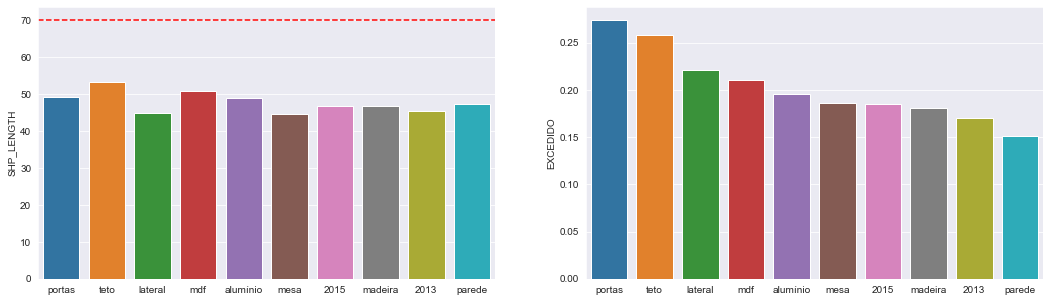

In [87]:
f, axes = plt.subplots(1, 2, figsize=(18, 5))

g = sns.barplot(x= top_excess_words.index, y= top_excess_words.SHP_LENGTH, ax=axes[0])
g = axes[0].axhline(70, ls='--', color='red')

g = sns.barplot(x= top_excess_words.index, y= top_excess_words.EXCEDIDO, ax=axes[1])